In [3]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

In [ ]:
pip install stardist

In [30]:
import os, shutil 
import numpy as numpy
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob 


Loading the data: MIP and FOCUS

In [1]:
from PIL import Image 
from tifffile import imread
import cellpose

img= Image.open('image_mip_jp.jpg')
img_lab= Image.open('image_mip_lab_jp.jpg')

img_2= Image.open('in1-sec.jpg')
img_2_lab= Image.open('in1-sec_lab.jpg')


<PIL.JpegImagePlugin.JpegImageFile image mode=L size=777x528 at 0x11D94993F40>
<PIL.JpegImagePlugin.JpegImageFile image mode=L size=777x528 at 0x11D81F61E50>


In [59]:
#Convert the image to a numpy array to be able to use it with the pretrained model of Cellpose 
#mip image: img
#focus image: img_2

import numpy as np

img_array = np.array(img)
img_lab_array = np.array(img_lab)

img_2_array = np.array(img_2)
img_2_lab_array = np.array(img_2_lab)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [60]:
# Define the model of Cellpose with the model type "nuclei"
model = models.Cellpose(gpu=False, model_type= 'nuclei')

In [68]:
# Train on the two type of images
masks, flows, styles, diams = model.eval(img_array, diameter=30, channels=[0, 0], flow_threshold=0.4)
masks_2, flows_2, styles_2, diams_2 = model.eval(img_2_array, diameter=30, channels=[0, 0], flow_threshold=0.4)

<class 'numpy.ndarray'>


In [62]:
#Define a few augmentation methods
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

100%|██████████| 9/9 [00:04<00:00,  2.21it/s]


DatasetMatching(criterion='iou', thresh=0.1, fp=2762, tp=2653, fn=11871, precision=0.4899353647276085, recall=0.18266317818782704, accuracy=0.15347680203633, f1=0.2661116405035358, n_true=14524, n_pred=5415, mean_true_score=0.02471854305702755, mean_matched_score=0.13532307552215156, panoptic_quality=0.03601104562518362, by_image=False)

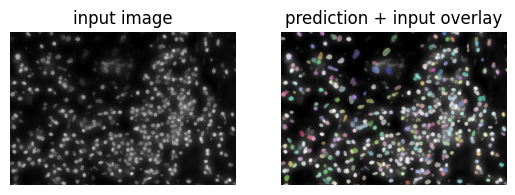

In [56]:
#Plot of the MIP images

from stardist.plot import render_label
from stardist.matching import matching, matching_dataset
from tqdm import tqdm



img_array_aug, img_lab_array_aug= augmenter(img_array, img_lab_array)



plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(masks, img=img_array))
plt.axis("off")
plt.title("prediction + input overlay")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(img_lab_array, masks, thresh=t, show_progress=False) for t in tqdm(taus)] # we can also compare with the augmentated image
stats[taus.index(0.1)]

100%|██████████| 9/9 [00:12<00:00,  1.39s/it]


DatasetMatching(criterion='iou', thresh=0.1, fp=36242, tp=7552, fn=114513, precision=0.1724437137507421, recall=0.06186867652480236, accuracy=0.047704776162772335, f1=0.09106530245570033, n_true=122065, n_pred=43794, mean_true_score=0.009478835537477278, mean_matched_score=0.1532089592004984, panoptic_quality=0.01395202020851644, by_image=False)

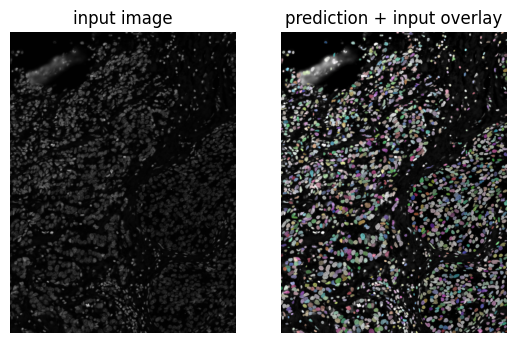

In [70]:
#Plot of the Focus images

from stardist.plot import render_label
from stardist.matching import matching, matching_dataset
from tqdm import tqdm



img_2_array_aug, img_2_lab_array_aug= augmenter(img_2_array, img_2_lab_array)

plt.subplot(1,2,1)
plt.imshow(img_2_array, cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(masks_2, img=img_2_array))  #verifier ces inputs
plt.axis("off")
plt.title("prediction + input overlay")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(img_2_lab_array, masks_2, thresh=t, show_progress=False) for t in tqdm(taus)] # we can also compare with the augmentated image
stats[taus.index(0.1)]

Some Results


Taus 0.3
before applying augmenter:
DatasetMatching(criterion='iou', thresh=0.3, fp=5394, tp=21, fn=14503, precision=0.003878116343490305, recall=0.001445882676948499, accuracy=0.0010543227231649764, f1=0.0021064245950147952, n_true=14524, n_pred=5415, mean_true_score=0.0005619641289800299, mean_matched_score=0.3886650956812359, panoptic_quality=0.000818693716766734, by_image=False)

with augmenter: 
DatasetMatching(criterion='iou', thresh=0.3, fp=5408, tp=7, fn=14517, precision=0.0012927054478301017, recall=0.00048196089231616635, accuracy=0.0003511940598033313, f1=0.0007021415316715983, n_true=14524, n_pred=5415, mean_true_score=0.00023409529301589004, mean_matched_score=0.4857142908232553, panoptic_quality=0.00034104017611342465, by_image=False)


Taus 0.1

without augmenter:
DatasetMatching(criterion='iou', thresh=0.1, fp=2762, tp=2653, fn=11871, precision=0.4899353647276085, recall=0.18266317818782704, accuracy=0.15347680203633, f1=0.2661116405035358, n_true=14524, n_pred=5415, mean_true_score=0.02471854305702755, mean_matched_score=0.13532307552215156, panoptic_quality=0.03601104562518362, by_image=False)


with augmenter:
DatasetMatching(criterion='iou', thresh=0.1, fp=4613, tp=802, fn=13722, precision=0.14810710987996306, recall=0.05521894794822363, accuracy=0.04190834509066207, f1=0.08044535834294599, n_true=14524, n_pred=5415, mean_true_score=0.007197879703679022, mean_matched_score=0.13035162695291036, panoptic_quality=0.01048618334081289, by_image=False)


